In [34]:
import time
import numpy as np
import pandas as pd


from nltk import word_tokenize
from package.TextEditor import Remove_repetitive_words, Remove_stop_words, List_cleaner

import seaborn as sns
import matplotlib.pyplot as plt
from dask import delayed
%matplotlib inline

In [4]:
df_data = pd.read_csv('data/complains_data.csv')
df_data.columns =['Date_received','Product', 'Sub_product', 'Issue', 'Sub_issue',
       'Consumer_complaint_narrative', 'Company_public_response', 'Company',
       'State', 'ZIP_code', 'Submitted_via', 'Date_sent_to_company','Company_response_to_consumer',
       'Complaint_ID']

In [5]:
df_data.head(2)

,Date_received,Product,Sub_product,Issue,Sub_issue,Consumer_complaint_narrative,Company_public_response,Company,State,ZIP_code,Submitted_via,Date_sent_to_company,Company_response_to_consumer,Complaint_ID
0,10/01/2016,Credit reporting,NaN,Incorrect information on credit report,Account status,I have outdated information on my credit repor...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AL,352XX,Web,10/05/2016,Closed with explanation,2141773
1,10/17/2016,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,I purchased a new car on XXXX XXXX. The car de...,NaN,"CITIZENS FINANCIAL GROUP, INC.",PA,177XX,Web,10/20/2016,Closed with explanation,2163100


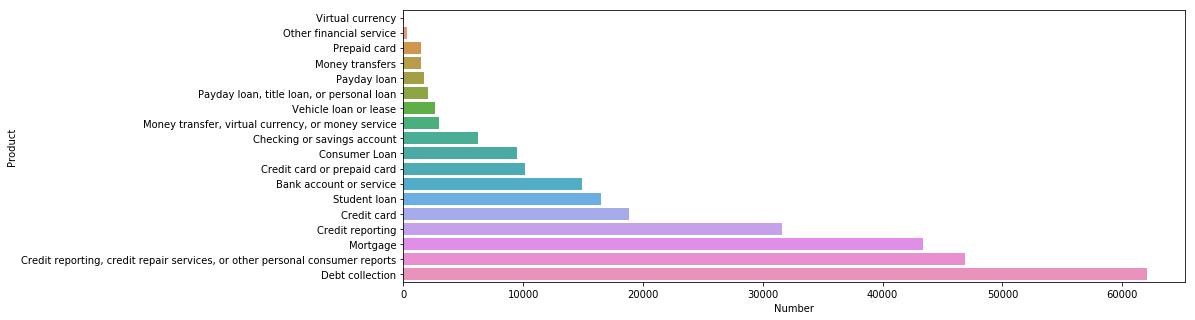

In [38]:
df_data['Number'] = np.ones(len(df_data))
xdata = df_data[['Product','Number']].groupby('Product').sum().sort_values('Number')

plt.figure(figsize=(14,5))
g = sns.barplot(x='Number', y=xdata.index , data=xdata )
#g.set_xticklabels(xdata.index,rotation=30)
plt.show()

In [6]:
%%time

def product(x):
    # 2. 
    if x[0] == 'Other financial service':
        x[1] = x[1]+' financial service'
    # 5.     
    elif x[0]=='Payday loan':
         x[1] = 'Payday loan'
    # 7.        
    elif x[0] == 'Vehicle loan or lease':
        if x[1] == "Title loan":
            x[1] = 'Vehicle loan'
        else:
            x[1] = 'Vehicle '+x[1]
     # 9.       
    elif x[0] == 'Consumer Loan':
        if x[1] == "Title loan":
            x[1] = 'loan'
        if x[1]=='Personal line of credit':
            x[1] = x[1]+' loan'
     # 13       
    elif x[0] == 'Credit card':
        x[1] ='Credit card'
    #14
    elif x[0] == 'Credit reporting':
        x[1] ='Credit reporting'
        
    # 15.
    elif x[0] == 'Mortgage':
        if x[1] == "Home equity loan or line of credit":
            x[1] = x[1]+' Mortgage'
        if x[1]=='Home equity loan or line of credit (HELOC)':
            x[1] = x[1]+' Mortgage'
    
    # 17.
    elif x[0] == 'Debt collection':
        if 'Debt'not in word_tokenize(x[1]): 
            x[1] = x[1]+' Debt'
    return x[1]
        
df_data['Sub_product'] = df_data[['Product','Sub_product']].apply(product, axis=1)

CPU times: user 37.3 s, sys: 206 ms, total: 37.5 s
Wall time: 37.8 s


In [7]:
df_data[['Issue','Sub_issue']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272657 entries, 0 to 272656
Data columns (total 2 columns):
Issue        272657 non-null object
Sub_issue    174509 non-null object
dtypes: object(2)
memory usage: 4.2+ MB


In [8]:
df_data['Sub_issue'].fillna('', inplace=True)

In [9]:
df = pd.DataFrame()
df['Date_received'] = df_data['Date_received']
df['Complaint_ID'] = df_data['Complaint_ID']
df["new_product"] = df_data['Product'] +' '+ df_data['Sub_product']
df['new_issue'] = df_data['Issue'] +' '+ df_data['Sub_issue']

In [14]:
df.head()

,Date_received,Complaint_ID,new_product,new_issue
0,10/01/2016,2141773,credit report,incorrect information credit report account st...
1,10/17/2016,2163100,consumer loan vehicle loan,managing loan leas
2,06/15/2015,1420702,credit report,credit reporting company investigation inadequ...
3,02/03/2016,1772196,debt collection phone health club etc,disclosure verification debt not given enough ...
4,02/17/2016,1790634,debt collection credit card,improper contact sharing info talked third par...


In [11]:
%%time

text1 = delayed(Remove_repetitive_words)(df['new_issue'],'Remove repetitive words from new_issue')
text1 = delayed(Remove_stop_words)(text1,'Remove stop_words from new_issue')
text1 = delayed(List_cleaner)(text1)
df['new_issue'] = text1.compute()

[272657/272657][Remove repetitive words from new_issue]*** Done! ***
[272657/272657][Remove stop_words from new_issue]*** Done! ***
[272657/272657][Clean every text]-- Done! --
CPU times: user 4min 36s, sys: 31.6 s, total: 5min 7s
Wall time: 4min 57s


In [13]:
text2 = delayed(Remove_repetitive_words)(df['new_product'], 'Remove repetitive words from new_product')
text2 = delayed(Remove_stop_words)(text2,'Remove stop_words from new_product')
text2 = delayed(List_cleaner)(text2)
df['new_product'] = text2.compute()

[272657/272657][Remove repetitive words from new_product]*** Done! ***
[272657/272657][Remove stop_words from new_product]*** Done! ***
[272657/272657][Clean every text]-- Done! --


In [15]:
df['new'] = df['new_product'] +' '+ df['new_issue']

In [16]:
df.head()

,Date_received,Complaint_ID,new_product,new_issue,new
0,10/01/2016,2141773,credit report,incorrect information credit report account st...,credit report incorrect information credit rep...
1,10/17/2016,2163100,consumer loan vehicle loan,managing loan leas,consumer loan vehicle loan managing loan leas
2,06/15/2015,1420702,credit report,credit reporting company investigation inadequ...,credit report credit reporting company investi...
3,02/03/2016,1772196,debt collection phone health club etc,disclosure verification debt not given enough ...,debt collection phone health club etc disclosu...
4,02/17/2016,1790634,debt collection credit card,improper contact sharing info talked third par...,debt collection credit card improper contact s...


In [20]:
from farhad.TextTalent import plot_frequency_distribution_of_ngrams
from wordcloud import WordCloud

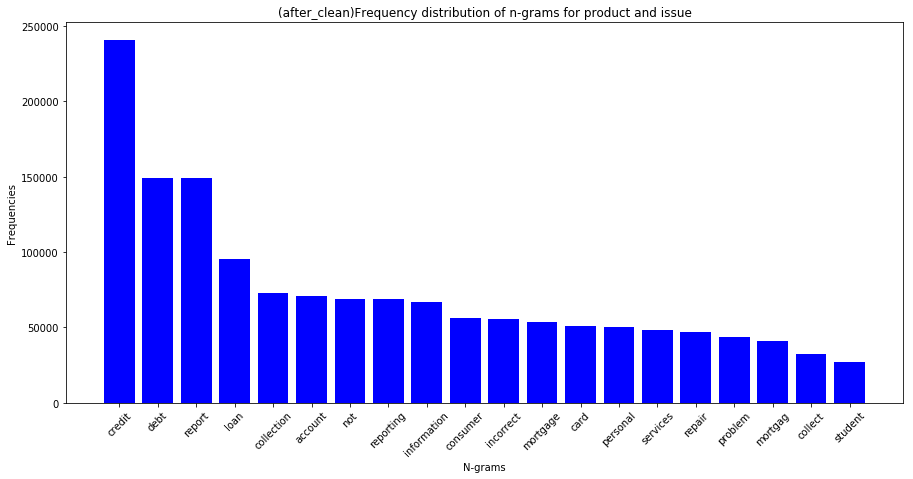

In [21]:
plt.figure(figsize=(15,7))
plot_frequency_distribution_of_ngrams(df['new'],ngram_range=(1, 2),
                                      num_ngrams=20, title='(after_clean)Frequency distribution of n-grams for product and issue')

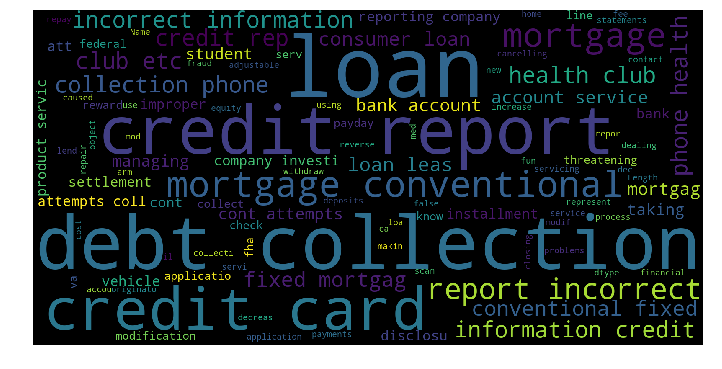

In [23]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(str(df['new']))
plt.figure(figsize=(12,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [18]:
df.to_csv('data/Clean_model_for_product_issue.csv',index=False)

# use Gensim for classfication

In [2]:
import pandas as pd
df = pd.read_csv('data/Clean_model_for_product_issue.csv')
df.head()

,Date_received,Complaint_ID,new_product,new_issue,new
0,10/01/2016,2141773,credit report,incorrect information credit report account st...,credit report incorrect information credit rep...
1,10/17/2016,2163100,consumer loan vehicle loan,managing loan leas,consumer loan vehicle loan managing loan leas
2,06/15/2015,1420702,credit report,credit reporting company investigation inadequ...,credit report credit reporting company investi...
3,02/03/2016,1772196,debt collection phone health club etc,disclosure verification debt not given enough ...,debt collection phone health club etc disclosu...
4,02/17/2016,1790634,debt collection credit card,improper contact sharing info talked third par...,debt collection credit card improper contact s...


In [2]:
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
import pyLDAvis.gensim
import gensim
from dask import delayed
import numpy as np
from nltk.tokenize import word_tokenize

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
import re 
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

## make dicationary

In [5]:
import en_core_web_sm
nlp = en_core_web_sm.load()

In [5]:
%%time
def bag_of_words_for_bigrams(x):
    x = word_tokenize(str(x))
    return x

def bag_of_words_for_Tigrams(x):
    x = word_tokenize(str(x))
    texts = []
    for i in range(len(x)-1):
        
        texts.append('{} {}'.format(x[i],x[i+1]))
    return texts
def make_dictionary(list1):
    bigram = gensim.models.Phrases(list1)
    texts =  [bigram[line] for line in list1]
    dictionary = Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    
    return corpus, dictionary

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 10 µs


# Check best model for n_grams:

In [4]:
%%time
def bag_of_words_for_bigrams(x):
    x = word_tokenize(str(x))
    return x

def bag_of_words_for_Tigrams(x):
    x = word_tokenize(str(x))
    texts = []
    for i in range(len(x)-1):
        
        texts.append('{} {}'.format(x[i],x[i+1]))
    return texts
def make_dictionary(list1):
    bigram = gensim.models.Phrases(list1)
    texts =  [bigram[line] for line in list1]
    dictionary = Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    
    return corpus, dictionary

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 11.2 µs


In [8]:
bigrams = df['new'].apply(bag_of_words_for_bigrams)

In [9]:
trigrams = df['new'].apply(bag_of_words_for_Tigrams)
bi_Tri_grams = bigrams+trigrams

In [11]:
%%time
corpus_bi, dictionary_bi = make_dictionary(bigrams)
corpus_ti, dictionary_ti = make_dictionary(trigrams)
corpus_biti, dictionary_biti = make_dictionary(bi_Tri_grams)

/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


CPU times: user 1min 56s, sys: 3.4 s, total: 2min
Wall time: 2min 12s


In [ ]:
# save
#import pickle
#pickle.dump(corpus, open('corpus.pkl', 'wb'))
#dictionary.save('dictionary.gensim')

In [18]:
%%time

warnings.filterwarnings("ignore")
ldamodel_bi = LdaModel(corpus=corpus_bi, 
                    num_topics=10, id2word=dictionary_bi ,update_every=1, chunksize=100)

CPU times: user 48 s, sys: 620 ms, total: 48.6 s
Wall time: 49.1 s


In [17]:
warnings.filterwarnings("ignore")
ldamodel_ti = LdaModel(corpus=corpus_ti, 
                    num_topics=10, id2word=dictionary_ti);


In [19]:
warnings.filterwarnings("ignore")
ldamodel_biti = LdaModel(corpus=corpus_biti, 
                    num_topics=10, id2word=dictionary_biti, passes=25,update_every=1, chunksize=100)

In [43]:
def evaluate_bar_graph(coherences, indices):
    """
    Function to plot bar graph.
    
    coherences: list of coherence values
    indices: Indices to be used to mark bars. Length of this and coherences should be equal.
    """
    assert len(coherences) == len(indices)
    n = len(coherences)
    y = np.arange(n)
    #plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    df = pd.DataFrame({'x':coherences,'y':y})
    g = sns.barplot(x='x',y='y', data=df)
    plt.xlabel('Models')
    #plt.xticks(coherences,('bi_grams', 'tri_grams', 'bitri_grams'))
    g.set_xticklabels(indices) 
    plt.ylabel('Coherence Value')

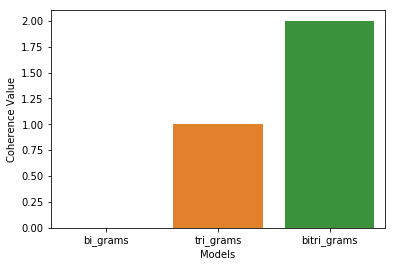

In [44]:
evaluate_bar_graph([ldamodel_bi , ldamodel_ti, ldamodel_biti],
                   ['bi_grams', 'tri_grams', 'bitri_grams'])

# Check best num_topics models:

In [21]:
def last_modify(df):
    new = []
    for texts in df:
        
        words = word_tokenize(texts)
        for word in words:
            if word=='mortgag':
                word='mortgage'
        new.append(' '.join(words)) 
    return new
df['new'] = last_modify(df['new'])

In [22]:
%%time
bigrams = df['new'].apply(bag_of_words_for_bigrams)
trigrams = df['new'].apply(bag_of_words_for_Tigrams)
bi_Tri_grams = bigrams+trigrams

CPU times: user 1min 20s, sys: 2.97 s, total: 1min 23s
Wall time: 1min 26s


In [23]:
%%time
corpus_biti, dictionary_biti = make_dictionary(bi_Tri_grams)

CPU times: user 52 s, sys: 1.32 s, total: 53.3 s
Wall time: 54.4 s


In [24]:
%%time
warnings.filterwarnings("ignore")
ldamodel_biti = LdaModel(corpus=corpus_biti, 
                    num_topics=10, id2word=dictionary_biti, passes=25,update_every=1, chunksize=100)

CPU times: user 21min 11s, sys: 9.04 s, total: 21min 20s
Wall time: 21min 36s


In [25]:
from itertools import chain
def find_probability_for_label(ldamodel, corpus):
    
    """
    This finctuion extract problitly for every row according to threshold
    
    """
    lda_corpus = ldamodel[corpus]
    
    #find threshold
    scores = list(chain(*[[score for topic_id,score in topic] \
                          for topic in [doc for doc in lda_corpus]]))
    threshold = sum(scores)/len(scores)
    print('threshold for probability:',threshold)
    
    #extract probability
    probabilityL_list, lebal_list = [],[]
    for ilab in lda_corpus:
        probilityL_list = [ilab[i][1] for i in len(ilab) if  ilab[i][1] > threshold]
        lebal_list = [ ilab[i][0] for i in len(ilab) if  ilab[i][1] > threshold ]
    return probilityL_list,lebal_list
def array_probablity_label(probilityL_list,lebal_list,num_topic):
    List_aray = []
    for labels in lebal_list:
        array = np.zeros(num_topic)
        for la in labels:
            array[la]= probilityL_list[la]
        List_aray.append(array)
    return List_aray

In [26]:
def evaluate_graph_for_max_label(dictionary, corpus, texts, limit):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in range(2, limit):
        lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(2, limit)
    m = (i for i in range(len(c_v)) if c_v[i]==max[c_v])
    print(max(c_v),m)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    

In [27]:
#ldamodel = LdaModel(corpus=corpus_biti, num_topics=10, id2word=dictionary_biti)

0.5683158720659915 <generator object evaluate_graph_for_max_label.<locals>.<genexpr> at 0x14c86b938>


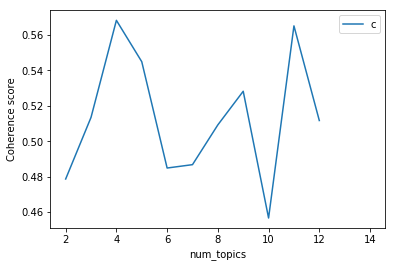

TypeError: 'NoneType' object is not iterable

In [28]:
%%time
warnings.filterwarnings("ignore")
evaluate_graph_for_max_label(dictionary_biti,  corpus_biti, bi_Tri_grams, limit=15)

<b> the Best are 4 , 9 and 11, respectively. 

# Used 11 for num_topics:

In [31]:
%%time
warnings.filterwarnings("ignore")
ldamodel_biti = LdaModel(corpus=corpus_biti, 
                    num_topics=11, id2word=dictionary_biti,update_every=1)

CPU times: user 1min 4s, sys: 615 ms, total: 1min 5s
Wall time: 1min 10s


In [33]:
#ldamodel.save()
ldamodel_biti.save('The_best_model_for_product_issue.gensim')

In [34]:
all_topics = ldamodel_biti.show_topics(num_topics=11)

In [175]:
def find_probility_for_label(ldamodel, corpus):
    
    """
    This finctuion extract probability for every row according to threshold
    
    Parameters:
    ----------
    ldamodel : model of LDA
    corpus : Gensim corpus
    
    
    Returns:
    -------
    probabilitylist : probabilitylist list for every row 
    leballist : label for ever row
    """
    lda_corpus = ldamodel[corpus]
    
    #find threshold
    scores = list(chain(*[[score for topic_id,score in topic] \
                          for topic in [doc for doc in lda_corpus]]))
    threshold = sum(scores)/len(scores)
    print('threshold for probability:',threshold)

    lda_corpus = ldamodel[corpus]
    #extract probability
    probilitylist =[]
    leballist = []
    for n in range(len(lda_corpus)): #len(lda_corpus)
        ilab = lda_corpus[n]
        probabilityL = [ilab[i][1] for i in range(len(ilab)) if  ilab[i][1] > threshold]
        lebal = [ ilab[i][0] for i in range(len(ilab)) if  ilab[i][1] > threshold ]
        #print(probilityL )
        #print(lebal)
        probilitylist.append(probabilityL)
        leballist.append(lebal)
        
        
    return probabilitylist,leballist

In [94]:
lda_corpus = ldamodel_biti[corpus_biti]

In [98]:
ilab = lda_corpus[0]

In [113]:
ilab[0][1]

0.9431811

In [153]:
%%time
probability_list,lebal_list = find_probility_for_label(ldamodel_biti, corpus_biti)

threshold for probability: 0.4207650144038845
CPU times: user 1min 2s, sys: 554 ms, total: 1min 2s
Wall time: 1min 3s


In [ ]:
probability

In [ ]:
[0.4768549, 0.47768915]
[4, 6]
8
-----------------
[0.4621572, 0.4793991]
[4, 6]
14
-----------------
[0.5039925, 0.43756467]
[6, 10]
29
-----------------
[0.4768546, 0.47768953]
[4, 6]
37
-----------------
[0.45916098, 0.50364864]
[0, 2]
43
-----------------
[0.459163, 0.50364655]
[0, 2]
97

In [179]:
def arrowforlebels(probability_list,lebal_list):
    """
    This finctuion get  problitly for evry row and compute a mount 
    probability for every class
    
    Parameters:
    ----------
   probabilitylist : probabilitylist list for every row  
    leballist : label for ever row
    
    
    Returns:
    -------
    porb : a probabilitylist for evry class (precent)
    
    
    """
    new_list = []
    for num in range(len(probability_list)):
        k = np.zeros(11)
        for i in range(len(probability_list[num])):
            k[lebal_list[num][i]] = probability_list[num][i]
        new_list.append(k)
    
    listt = []
    for i in range(11):
    listt.append([])
    for j in range(len(arrow_probability)):
        listt[i].append(arrow_probability[j][i])
    porb = []
    for i in range(len(listt)):
        porb.append(round(sum(listt[i])*100/sum(s),2))
    return porb
porb =  arrowforlebels(probability_list,lebal_list)

In [5]:
porb = [3.85, 14.93, 3.03, 7.74, 4.95, 5.22, 9.07, 11.06, 4.83, 27.23, 8.1]

Text(0.5, 1.0, 'possible for every class (LDA classfication)')

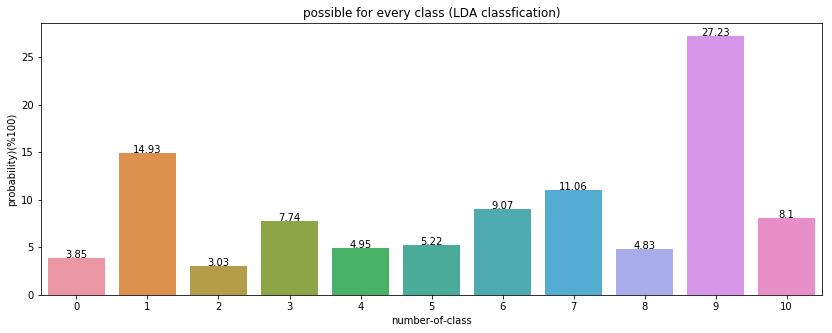

In [6]:
plt.figure(figsize=(14,5))
g = sns.barplot(x=np.arange(0,11),y=porb)
for i in range(11):
      g.text(i,porb[i], round(porb[i],2), color='black', ha="center")
plt.xlabel("number-of-class")
plt.ylabel('probability)(%100)')
plt.title('possible for every class (LDA classfication)')

In [46]:
plt.figure(figsize=(10,8))
p = pyLDAvis.enable_notebook()
p = pyLDAvis.gensim.prepare(ldamodel_biti, corpus_biti, dictionary_biti)

<Figure size 720x576 with 0 Axes>

In [50]:
pyLDAvis.gensim.prepare(ldamodel_biti, corpus_biti, dictionary_biti)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
9      29.625277        1       1 -0.149360  0.226028
7      11.766294        1       2  0.312495 -0.048179
1       9.714588        1       3 -0.129804  0.248545
3       7.766210        1       4 -0.176334 -0.230769
6       6.843896        1       5 -0.176497 -0.263374
10      6.620775        1       6 -0.200217 -0.194905
4       6.351676        1       7 -0.193125  0.200130
8       6.294817        1       8  0.199523  0.084471
5       5.952066        1       9  0.006945  0.065313
0       4.975309        1      10  0.299958 -0.061664
2       4.089092        1      11  0.206414 -0.025596, topic_info=     Category           Freq                   Term          Total  loglift  \
term                                                                          
15    Default  158088.000000                   loan  158088.000000  30.0000   
40    Default  185568.000000                   debt  185568.000000  29.0000   
101   Default   85565.000000                problem   85565.000000  28.0000   
2     Default  220575.000000                 credit  220575.000000  27.0000   
23    Default   50408.000000                company   50408.000000  26.0000   
8     Default  113734.000000                 report  113734.000000  25.0000   
35    Default   39960.000000      reporting company   39960.000000  24.0000   
30    Default   35122.000000          investigation   35122.000000  23.0000   
34    Default   82457.000000              reporting   82457.000000  22.0000   
62    Default   49943.000000                   card   49943.000000  21.0000   
25    Default   78695.000000       credit reporting   78695.000000  20.0000   
24    Default   32410.000000  company investigation   32410.000000  19.0000   
41    Default   67476.000000        debt collection   67476.000000  18.0000   
38    Default   73401.000000             collection   73401.000000  17.0000   
21    Default   30387.000000                vehicle   30387.000000  16.0000   
84    Default   35262.000000                mortgag   35262.000000  15.0000   
632   Default   63532.000000               personal   63532.000000  14.0000   
67    Default   42664.000000            credit card   42664.000000  13.0000   
239   Default   29455.000000                student   29455.000000  12.0000   
0     Default   48902.000000                account   48902.000000  11.0000   
86    Default   37190.000000               mortgage   37190.000000  10.0000   
637   Default   60445.000000               services   60445.000000   9.0000   
22    Default   27213.000000           vehicle loan   27213.000000   8.0000   
159   Default   58829.000000          credit repair   58829.000000   7.0000   
164   Default   58829.000000                 repair   58829.000000   6.0000   
636   Default   58828.000000       reporting credit   58828.000000   5.0000   
638   Default   58828.000000      services personal   58828.000000   4.0000   
633   Default   58828.000000      personal consumer   58828.000000   3.0000   
634   Default   58828.000000        repair services   58828.000000   2.0000   
630   Default   57719.000000        consumer report   57719.000000   1.0000   
...       ...            ...                    ...            ...      ...   
312   Topic11    3942.820068       tactics frequent    3944.007568   3.1965   
308   Topic11    3942.820068      frequent repeated    3944.007568   3.1965   
310   Topic11    3942.820068           repeated cal    3944.007568   3.1965   
370   Topic11    2218.547363     know communication    2219.734863   3.1963   
1174  Topic11    2212.328613                   told    2213.516113   3.1963   
1172  Topic11    2063.052246        stop contacting    2064.239746   3.1963   
1173  Topic11    2063.052246           tactics told    2064.239746   3.1963   
1171  Topic11    2063.052246               keep tri    2064.239746   3.1963   
1176  Topic11   

In [49]:
pyLDAvis.save_html(p, 'lda_for_product_issue.html')

In [77]:
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)
#hdpmodel.show_topics()

In [78]:
plt.figure(figsize=(14,5))
p = pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(hdpmodel, corpus, dictionary)

PreparedData(topic_coordinates=               Freq  cluster  topics         x         y
topic                                                   
1      1.394273e+01        1       1  0.015938 -0.032328
4      1.330208e+01        1       2 -0.036804  0.007930
80     8.916483e+00        1       3  0.055347 -0.001896
16     7.480170e+00        1       4  0.005504 -0.053362
2      5.789595e+00        1       5 -0.036676 -0.025089
7      5.588487e+00        1       6  0.036180  0.005924
27     5.029504e+00        1       7  0.003196 -0.050111
146    4.713510e+00        1       8  0.051800 -0.012789
3      4.621072e+00        1       9 -0.000611 -0.006753
0      4.467942e+00        1      10  0.021137 -0.038002
69     4.364228e+00        1      11  0.031446 -0.034282
145    2.258356e+00        1      12  0.020674  0.040897
23     2.088303e+00        1      13  0.041383 -0.028413
14     2.006285e+00        1      14  0.036203 -0.054281
12     1.803745e+00        1      15 -0.024046 -0.000688
129    1.659891e+00        1      16 -0.015366 -0.045208
24     1.558003e+00        1      17 -0.059660 -0.016902
5      1.400019e+00        1      18 -0.016980  0.050521
68     1.131331e+00        1      19  0.031788  0.052892
25     1.001782e+00        1      20 -0.025353  0.005167
6      6.517586e-01        1      21 -0.022045  0.002362
40     6.474992e-01        1      22 -0.010321 -0.029416
8      5.486534e-01        1      23 -0.001886  0.031236
9      5.307507e-01        1      24  0.003397 -0.016945
10     4.692026e-01        1      25 -0.028949 -0.034072
11     4.508871e-01        1      26 -0.047976  0.011617
13     3.759209e-01        1      27 -0.035920 -0.023915
15     3.600390e-01        1      28  0.043415 -0.047343
17     2.718086e-01        1      29 -0.008206  0.022144
18     2.661862e-01        1      30  0.020545  0.050167
...             ...      ...     ...       ...       ...
117    4.070799e-07        1     121  0.017447 -0.035464
118    3.137883e-07        1     122 -0.041873  0.074957
119    2.543018e-07        1     123 -0.012558 -0.019275
120    1.891506e-07        1     124  0.021001 -0.056677
121    1.558077e-07        1     125 -0.019511  0.051228
122    1.206314e-07        1     126 -0.012746  0.011730
123    8.790199e-08        1     127  0.014508  0.003669
124    6.798098e-08        1     128  0.038557 -0.046887
125    4.817180e-08        1     129 -0.056897 -0.025971
126    3.401004e-08        1     130 -0.042180 -0.011187
127    2.636207e-08        1     131 -0.027923  0.013948
128    1.995069e-08        1     132  0.021562 -0.004046
130    1.027243e-08        1     133  0.015294 -0.018358
131    7.447453e-09        1     134 -0.004018 -0.027465
132    5.042285e-09        1     135 -0.020961  0.018648
133    3.823727e-09        1     136  0.082925  0.020122
134    2.537945e-09        1     137 -0.032315  0.039370
135    1.723599e-09        1     138 -0.008299  0.018649
136    1.216633e-09        1     139 -0.027801  0.029850
137    8.149374e-10        1     140  0.005810 -0.000889
138    5.702273e-10        1     141  0.046161  0.026322
139    3.528127e-10        1     142 -0.024743 -0.019522
140    2.353272e-10        1     143 -0.070353 -0.040260
141    1.394419e-10        1     144 -0.017861  0.028812
142    9.181148e-11        1     145  0.026187 -0.045999
143    5.322515e-11        1     146 -0.029501 -0.027498
144    3.238766e-11        1     147 -0.024467 -0.017901
147    5.695537e-12        1     148 -0.034633 -0.002730
148    3.276640e-12        1     149 -0.014777  0.016294
149    3.235975e-12        1     150  0.001473 -0.016518

[150 rows x 5 columns], topic_info=      Category          Freq          Term     Total  loglift  logprob
term                                                                  
7      Default  7.000000e+00          loan  7.000000  30.0000  30.0000
56     Default  6.000000e+00         cause  6.000000  29.0000  29.0000
86     Default  6.000000e+00       process  6.000000  28.0

<Figure size 1008x360 with 0 Axes>

In [79]:
lsimodel = LsiModel(corpus=corpus, num_topics=10, id2word=dictionary)

In [80]:
plt.figure(figsize=(14,5))
p = pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(hdpmodel, corpus, dictionary)

PreparedData(topic_coordinates=               Freq  cluster  topics         x         y
topic                                                   
1      1.394273e+01        1       1  0.015938 -0.032328
4      1.330208e+01        1       2 -0.036804  0.007930
80     8.916483e+00        1       3  0.055347 -0.001896
16     7.480170e+00        1       4  0.005504 -0.053362
2      5.789595e+00        1       5 -0.036676 -0.025089
7      5.588487e+00        1       6  0.036180  0.005924
27     5.029504e+00        1       7  0.003196 -0.050111
146    4.713510e+00        1       8  0.051800 -0.012789
3      4.621072e+00        1       9 -0.000611 -0.006753
0      4.467942e+00        1      10  0.021137 -0.038002
69     4.364228e+00        1      11  0.031446 -0.034282
145    2.258356e+00        1      12  0.020674  0.040897
23     2.088303e+00        1      13  0.041383 -0.028413
14     2.006285e+00        1      14  0.036203 -0.054281
12     1.803745e+00        1      15 -0.024046 -0.000688
129    1.659891e+00        1      16 -0.015366 -0.045208
24     1.558003e+00        1      17 -0.059660 -0.016902
5      1.400019e+00        1      18 -0.016980  0.050521
68     1.131331e+00        1      19  0.031788  0.052892
25     1.001782e+00        1      20 -0.025353  0.005167
6      6.517586e-01        1      21 -0.022045  0.002362
40     6.474992e-01        1      22 -0.010321 -0.029416
8      5.486534e-01        1      23 -0.001886  0.031236
9      5.307507e-01        1      24  0.003397 -0.016945
10     4.692026e-01        1      25 -0.028949 -0.034072
11     4.508871e-01        1      26 -0.047976  0.011617
13     3.759209e-01        1      27 -0.035920 -0.023915
15     3.600390e-01        1      28  0.043415 -0.047343
17     2.718086e-01        1      29 -0.008206  0.022144
18     2.661862e-01        1      30  0.020545  0.050167
...             ...      ...     ...       ...       ...
117    4.070799e-07        1     121  0.017447 -0.035464
118    3.137883e-07        1     122 -0.041873  0.074957
119    2.543018e-07        1     123 -0.012558 -0.019275
120    1.891506e-07        1     124  0.021001 -0.056677
121    1.558077e-07        1     125 -0.019511  0.051228
122    1.206314e-07        1     126 -0.012746  0.011730
123    8.790199e-08        1     127  0.014508  0.003669
124    6.798098e-08        1     128  0.038557 -0.046887
125    4.817180e-08        1     129 -0.056897 -0.025971
126    3.401004e-08        1     130 -0.042180 -0.011187
127    2.636207e-08        1     131 -0.027923  0.013948
128    1.995069e-08        1     132  0.021562 -0.004046
130    1.027243e-08        1     133  0.015294 -0.018358
131    7.447453e-09        1     134 -0.004018 -0.027465
132    5.042285e-09        1     135 -0.020961  0.018648
133    3.823727e-09        1     136  0.082925  0.020122
134    2.537945e-09        1     137 -0.032315  0.039370
135    1.723599e-09        1     138 -0.008299  0.018649
136    1.216633e-09        1     139 -0.027801  0.029850
137    8.149374e-10        1     140  0.005810 -0.000889
138    5.702273e-10        1     141  0.046161  0.026322
139    3.528127e-10        1     142 -0.024743 -0.019522
140    2.353272e-10        1     143 -0.070353 -0.040260
141    1.394419e-10        1     144 -0.017861  0.028812
142    9.181148e-11        1     145  0.026187 -0.045999
143    5.322515e-11        1     146 -0.029501 -0.027498
144    3.238766e-11        1     147 -0.024467 -0.017901
147    5.695537e-12        1     148 -0.034633 -0.002730
148    3.276640e-12        1     149 -0.014777  0.016294
149    3.235975e-12        1     150  0.001473 -0.016518

[150 rows x 5 columns], topic_info=      Category          Freq          Term     Total  loglift  logprob
term                                                                  
7      Default  7.000000e+00          loan  7.000000  30.0000  30.0000
56     Default  6.000000e+00         cause  6.000000  29.0000  29.0000
86     Default  6.000000e+00       process  6.000000  28.0

<Figure size 1008x360 with 0 Axes>

# TI_TDF

In [115]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

In [ ]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))